# Correct Bleaching in bongwoori dataset

## User Input

**Note: Tiff files should be uint8. Can only handle single planes
Press alt+f to run the entire file**

In [57]:
#Name of tif file
Filename = '/Users/seetha/Desktop/Bleach_Correction/Data/8bit/7dpf2leftOBodor.tif'

# Stimulus on and off time
stimulus_on_time = [0]
stimulus_off_time = [0]

#Background ROI
bg_roi_wh = [50, 50]
start_point = [0, 0]

### Import libraries 

In [134]:
# libraries
from tifffile import TiffFile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from thunder import Colorize
import seaborn as sns
import fit
import cv2
from scipy.optimize import curve_fit
from copy import copy
from skimage.morphology import erosion
from skimage.morphology import disk
import os
from scipy.ndimage.filters import median_filter
from smooth import smooth

filesep = os.path.sep
image = Colorize.image
%matplotlib inline

## Load Image and subtract background

### Load tif file

In [59]:
#Load tif file
with TiffFile(Filename) as tif:
    images = tif.asarray()
    
print 'Size of Image File (t,x,y): ' + str(np.shape(images))
print 'Data Type: ' + str(images.dtype)


if images.dtype != 'uint8':
    raise(ValueError('Image is not uint8. Please convert with ImageJ before proceeding'))
else:
    t,x,y = np.shape(images)
    images_pixels = np.reshape(images, (t,x*y))

Size of Image File (t,x,y): (500, 256, 256)
Data Type: uint8


### Background subtraction of image using user input

In [60]:
#Get background subtracted data
bg_image_trace = images[:, start_point[0]:start_point[0]+bg_roi_wh[0], 
                        start_point[1]:start_point[1]+bg_roi_wh[1]]
shape_bg_image = np.shape(bg_image_trace)
bg_image_trace = np.reshape(bg_image_trace, (shape_bg_image[0],shape_bg_image[1]*shape_bg_image[2]))

# Subtract background and replot
bg_image = np.mean(bg_image_trace,1)
bg_image = np.repeat(bg_image[:,np.newaxis], np.size(images,1) , 1)
bg_image = np.repeat(bg_image[:,:,np.newaxis], np.size(images,2), 2)

shape_bg_image = np.shape(bg_image)
bg_subtracted_image = images - bg_image

print 'Data Type: ' + str(bg_subtracted_image.dtype)

Data Type: float64


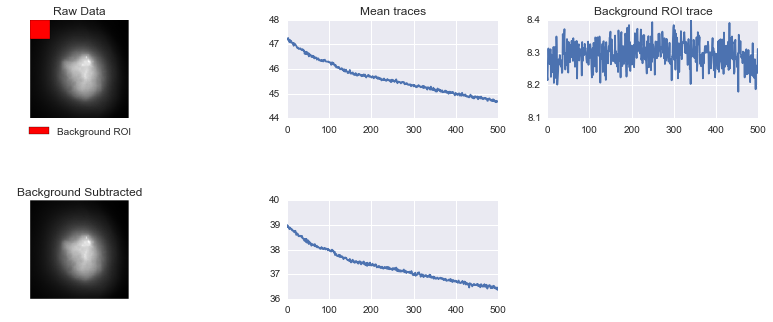

In [61]:
#Plots of raw and background subtracted image
with sns.axes_style('darkgrid'):
    fig2 = plt.figure(figsize=(15,5))
    gs = plt.GridSpec(3, 3, width_ratios=[1.5,1,1], height_ratios=[2,1,2])

    #Plot image
    ax1 =  fig2.add_subplot(gs[0,0])
    image(np.mean(images,0), cmap='gray')
    plt.grid('on')
    plt.title('Raw Data')
    h = ax1.add_patch(patches.Rectangle((start_point[0], start_point[1]),
                                    bg_roi_wh[0],bg_roi_wh[1],facecolor="red", label='Background ROI'))
    plt.legend(loc=9, bbox_to_anchor=(0.5,0))
    
    #Plot mean trace
    ax2 = fig2.add_subplot(gs[0,1])
    ax2.plot(np.mean(images_pixels,1))
    ax2.locator_params(axis='y', nbins=4)
    plt.title('Mean traces')
    
    #plot background trace
    ax3 = fig2.add_subplot(gs[0,2])
    ax3.plot(np.mean(bg_image_trace,1))
    ax3.locator_params(axis='y', nbins=4)
    plt.title('Background ROI trace')

    #Plot bg subtracted image
    ax4 =  fig2.add_subplot(gs[2,0])
    image(np.mean(bg_subtracted_image,0), cmap='gray')
    plt.title('Background Subtracted')
    plt.grid('on')

    #Plot mean trace from background subtracted image
    ax5 =  fig2.add_subplot(gs[2,1])
    shape_bg_subtracted_image = np.shape(bg_subtracted_image)
    bg_subtracted_image_pixels = np.reshape(bg_subtracted_image, 
                                            (shape_bg_subtracted_image[0],
                                             shape_bg_subtracted_image[1]*shape_bg_subtracted_image[2]))
    ax5.plot(np.mean(bg_subtracted_image_pixels, 1))
    ax5.locator_params(axis='y', nbins=4)


## Bleach Correction Algorithm

### Step1 : Get only Gcamp Labelled area of the image using standard deviation

Standard Deviation is : 50.071816128
Data Type: uint8


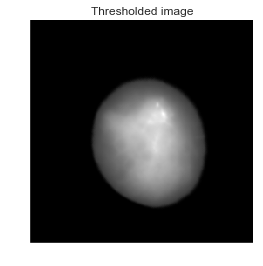

In [62]:
# Get all pixels above standard deviation and plot
Gcamp_images = copy(bg_subtracted_image)
low_values_indices = bg_subtracted_image < np.std(bg_subtracted_image)  # Where values are low
Gcamp_images[low_values_indices] = 0  # All

# Remove noise with morphological filters
out = np.zeros(np.shape(Gcamp_images), dtype=np.uint8)

for ii in range(0, np.size(Gcamp_images,0)):
    img = Gcamp_images[ii,:,:].astype(np.uint8)
    img_bw = (Gcamp_images[ii,:,:]>0).astype(np.uint8)
    
    selem = disk(1)
    out[ii,:,:] = erosion(img, selem)
    
Gcamp_images = out

print 'Standard Deviation is : ' + str(np.std(bg_subtracted_image))
print 'Data Type: ' + str(Gcamp_images.dtype)

#Plot Gcamp labelled image
with sns.axes_style('darkgrid'):
    image(np.mean(Gcamp_images, 0), cmap='gray')
    plt.title('Thresholded image')
    

### Step 2 : Normalize image using a background frame 

In [63]:
# Decide on a background frame
background_frame = np.squeeze(bg_subtracted_image[5,:,:])

# Divide each frame by the background frame
normalized_image = np.divide(bg_subtracted_image, (np.repeat(background_frame[np.newaxis, :,:], 500, 0)+0.00001))
thresholded_gcamp = np.mean(Gcamp_images,0)>0

#Multiply by the thresholded image to get only pixels of Gcamp 
normalized_image = normalized_image * thresholded_gcamp

#Dont use the first few frames for fitting
normalized_image = normalized_image[11:,:,:]

(489, 256, 256)
Data Type: float64


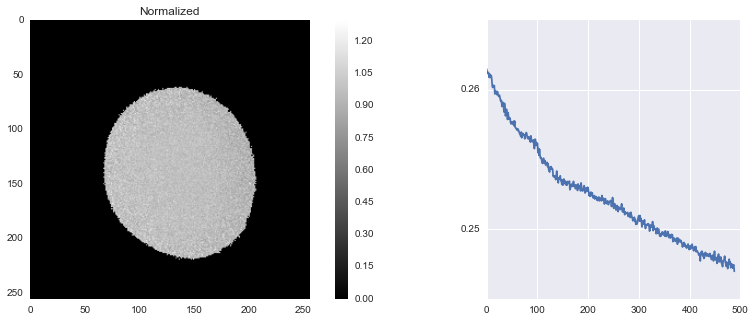

In [64]:
# Plot normalized image and trace
print np.shape(normalized_image)
print 'Data Type: ' + str(normalized_image.dtype)

with sns.axes_style('darkgrid'):
    fig2 = plt.figure(figsize=(15,5))
    gs = plt.GridSpec(1, 2, width_ratios=[2,1])
    ax1 =  fig2.add_subplot(gs[0,0])
    plt.imshow(np.mean(normalized_image,0), cmap='gray')
    plt.colorbar()
    plt.title('Normalized')
    plt.grid('off')
    
    
    ax5 = fig2.add_subplot(gs[0,1])
    shape_normalized_image = np.shape(normalized_image)
    normalized_image_pixels = np.reshape(normalized_image, 
                                            (shape_normalized_image[0],
                                             shape_normalized_image[1]*shape_normalized_image[2]))
    ax5.plot(np.mean(normalized_image_pixels,1))
    ax5.locator_params(axis='y', nbins=4)

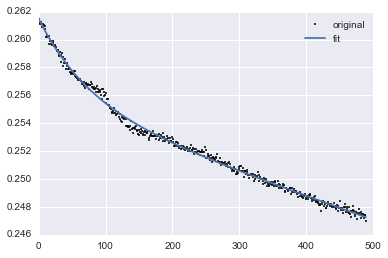

In [65]:
#Define exponential function
def func(x, a, b, c, d):
    return a*np.exp(-b*x) + c*np.exp(-d*x)

y = np.mean(normalized_image_pixels, 1)
x = np.linspace(0, np.size(normalized_image,0), np.size(normalized_image,0))

popt, pcov = curve_fit(func, x, y, p0=(1, 1e-6, 1, 1e-6))

yy = func(x, *popt)

#Plot fit
with sns.axes_style('darkgrid'):
    plt.plot(x, y, 'ko', markersize=2, label='original')
    plt.plot(x, yy, label='fit')
    plt.legend()


### Step 3. Subtract fit from each pixel

In [141]:
correct_image = np.zeros(np.shape(normalized_image))
for ii in xrange(0, np.size(normalized_image,0)):
    current_image = normalized_image[ii,:,:]
    correct_image[ii,:,:] = current_image - yy[ii] #temp_diff
print np.shape(correct_image[:])

(488, 256)


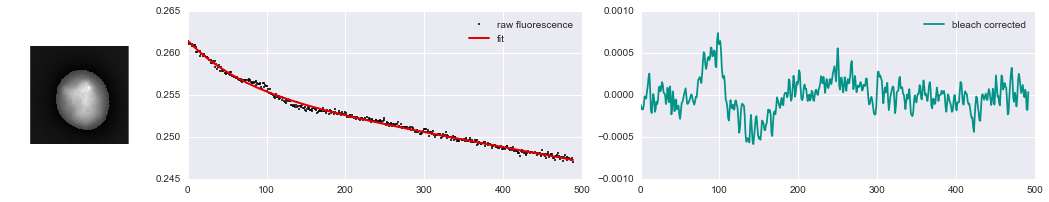

In [152]:
raw_correct_image = np.multiply(correct_image, (np.repeat(background_frame[np.newaxis, :,:], np.size(normalized_image,0), 0)))

smooth_window = 5
filtered_correct_image = np.zeros((np.size(correct_image, 0) + smooth_window -1 , np.size(correct_image,1), 
                                   np.size(correct_image,2)))
for ii in xrange(0, np.size(correct_image,1)):
    for jj in xrange(0, np.size(correct_image,2)):
        if sum(correct_image[:, ii, jj]) == 0:
            filtered_correct_image [:, ii, jj] = correct_image[:, ii, jj]
        else:
            filtered_correct_image [:, ii, jj] = smooth(correct_image[:, ii, jj], smooth_window, 'hanning') 
        
with sns.axes_style('darkgrid'):
    fig1 = plt.figure(figsize=(18,3))
    gs = plt.GridSpec(1, 3, width_ratios=[0.5,2,2])
    
    #Plot image
    ax1 = fig1.add_subplot(gs[0,0])
    image(np.mean(raw_correct_image,0))
    
    ax2 = fig1.add_subplot(gs[0,1])
    plt.plot(x, y, 'ko', markersize=2, label='raw fluorescence')
    plt.plot(x, yy, color='#e50000', linewidth=2, label='fit')
    plt.legend()
    ax2.locator_params(axis='y', nbins=6)
    
    ax3 = fig1.add_subplot(gs[0,2])
    plt.plot(np.mean(np.reshape(filtered_correct_image,  (shape_normalized_image[0]+smooth_window-1,
                                                 shape_normalized_image[1]*shape_normalized_image[2])),1), 
                     color='#029386', label='bleach corrected')
    plt.legend()
    ax3.locator_params(axis='y', nbins=4)
    
    fig1.savefig('Bleach corrected.pdf')
    

### Step 4. Convert to text and save

In [175]:
array_for_textfile = np.zeros((np.size(filtered_correct_image,1)*np.size(filtered_correct_image,2), 
                               3+np.size(filtered_correct_image,0)))
print np.shape(array_for_textfile)
array_for_textfile[:,2] = 1

count = 0
for ii in xrange(0, np.size(filtered_correct_image,1)):
    for jj in xrange(0, np.size(filtered_correct_image,2)):
        array_for_textfile[count, 0] = ii
        array_for_textfile[count, 1] = jj
        array_for_textfile[count, 3:] = filtered_correct_image[:, ii, jj]
        count += 1
        
Working_Directory, Tif_filename = os.path.split(Filename)
Save_Directory = os.path.join(Working_Directory, 'Text_Files')
if not os.path.exists(Save_Directory):
    os.makedirs(Save_Directory)

Text_filepath = Save_Directory + filesep + Tif_filename[:-4] + '.txt'
np.savetxt(Text_filepath, array_for_textfile, fmt='%f') 


(65536, 496)
